
This Notebook uses the csv files created by "Seatfinder_Sql_to_csv.ipynb", "Seatfinder_DataCleaning.ipynb" (using Jessy's locations file from the group chat), and "Seatfinder_DataMerging.ipynb".
It applies the stress measure we agreed on to the data to determine which time periods we should classify as "Exam Phases".

# Checking out available csv files


In [3]:
import pandas as pd

final_data_df = pd.read_csv("data/final_data.csv")
final_data_df

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability
0,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0,NaN
1,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0,NaN
2,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0,NaN
3,2016-04-12 13:00:00,6,NaN,NaN,NaN,NaN,21,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,NaN
4,2016-04-12 13:00:00,7,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338729,2024-10-15 13:10:00,15,9.0,92.0,NaN,NaN,17,"Alte Waschhalle, vorne",101,08:00:00,00:00:00,2,0,0.910891
3338730,2024-10-15 13:10:00,16,1.0,30.0,NaN,NaN,2,"Alte Waschhalle, hinten",31,08:00:00,00:00:00,2,0,0.967742
3338731,2024-10-15 13:10:00,17,44.0,16.0,NaN,NaN,50,"Bereichsbibliothek Naturwissenschaften, EG",60,08:00:00,19:45:00,5,1,0.266667
3338732,2024-10-15 13:10:00,18,56.0,2.0,NaN,NaN,61,"PCB-Bibliothek, EG",57,08:00:00,19:45:00,3,1,0.034483


# Making Polar Plots just because

/tmp/nix-shell.0OH1vU/ipykernel_10439/4040918081.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr', len(years))   # yellow→brown colormap


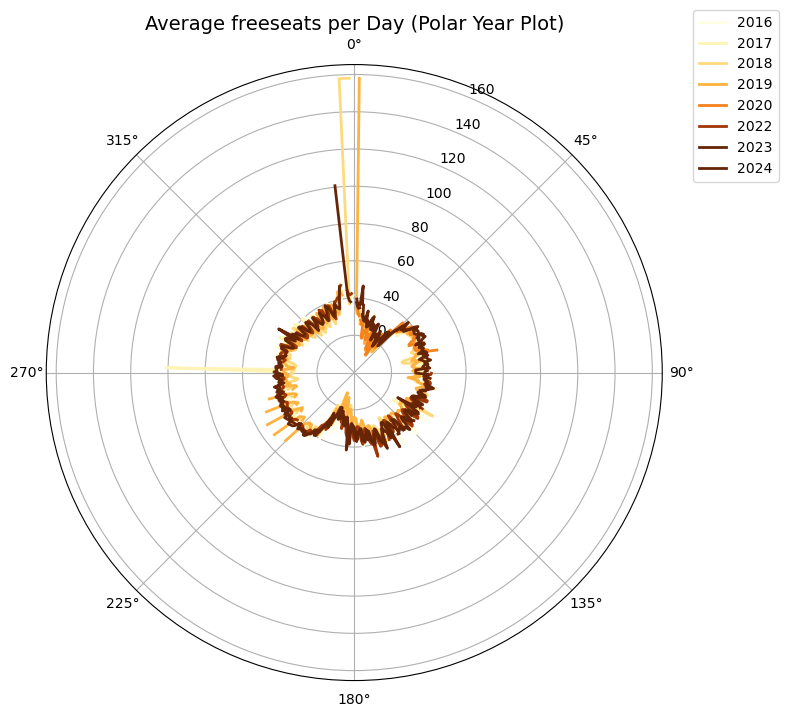

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Preprocessing -----------------------------------------------------------

df = final_data_df.copy()
df['t10'] = pd.to_datetime(df['t10'])

# Add year and day-of-year
df['year'] = df['t10'].dt.year
df['doy']  = df['t10'].dt.dayofyear

# Compute average freeseats per day for each year
daily_avg = (
    df.groupby(['year','doy'])['freeseats']
      .mean()
      .reset_index()
)

# Set up the polar plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')

# Full circle
max_doy = 366  # to handle leap years gracefully
theta = 2 * np.pi * daily_avg['doy'] / max_doy

# --- Color settings: darker brown each year ---------------------------------

years = sorted(daily_avg['year'].unique())
cmap = mpl.cm.get_cmap('YlOrBr', len(years))   # yellow→brown colormap

# Normalize colors so darker = later years
norm = mpl.colors.Normalize(vmin=min(years), vmax=max(years))

# --- Plot --------------------------------------------------------------------

for i, y in enumerate(years):
    ydf = daily_avg[daily_avg['year'] == y]

    theta = 2 * np.pi * ydf['doy'] / max_doy
    r = ydf['freeseats']

    ax.plot(theta, r,
            color=cmap(norm(y)),
            linewidth=2,
            label=str(y))

# Formatting
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Average freeseats per Day (Polar Year Plot)", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()


/tmp/nix-shell.0OH1vU/ipykernel_10439/3965126917.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr', len(normal_years))


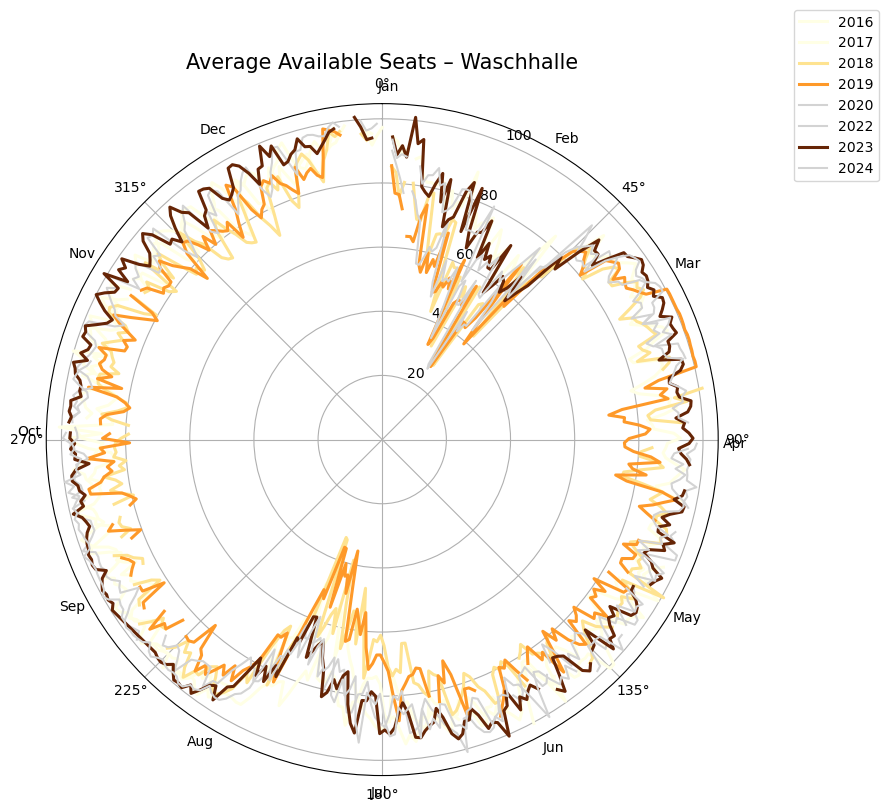

In [43]:
# Waschhalle only

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

max_doy = 365

# --- Filter ---------------------------------------------------------------
df = final_data_df.copy()
df = df[df['location_id'] == 15]   # <— only Waschhalle rows
df['t10'] = pd.to_datetime(df['t10'])

# --- Preprocessing --------------------------------------------------------
df['year'] = df['t10'].dt.year
df['doy']  = df['t10'].dt.dayofyear

# Avg per day
daily_avg = (
    df.groupby(['year','doy'])['freeseats']
      .mean()
      .reset_index()
)

# --- Plot ---------------------------------------------------------------
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='polar')
# --- Plot --------------------------------------------------------------------

exclude_years = {2020, 2021, 2022, 2024}

years = sorted(daily_avg['year'].unique())

# Brownish colormap (only for non-excluded years)
normal_years = [y for y in years if y not in exclude_years]
cmap = mpl.cm.get_cmap('YlOrBr', len(normal_years))
norm = mpl.colors.Normalize(vmin=min(normal_years), vmax=max(normal_years))

for y in years:
    ydf = daily_avg[daily_avg['year'] == y]
    theta = 2 * np.pi * ydf['doy'] / max_doy
    r = ydf['freeseats']

    # --- Color selection -----------------------------------------------------
    if y in exclude_years:
        color = "lightgray"         # or "gray", "#AAAAAA", etc.
        lw = 1.5
    else:
        color = cmap(norm(y))
        lw = 2.2

    ax.plot(theta, r, color=color, linewidth=lw, label=str(y))


# --- Month labels ---------------------------------------------------------

# Use the first year available for month conversion
example_year = years[0]
month_starts = pd.date_range(start=f"{example_year}-01-01", 
                             end=f"{example_year}-12-01", 
                             freq='MS')

# Add month labels at the right angles
for dt in month_starts:
    doy = dt.timetuple().tm_yday
    theta = 2 * np.pi * doy / max_doy
    ax.text(theta, ax.get_rmax()*1.05, dt.strftime("%b"),
            ha='center', va='center', fontsize=10)

# Orientation
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.set_title("Average Available Seats – Waschhalle", fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15))

plt.tight_layout()
plt.show()

# Availability Index

For each day, how many entries do we have with libraries over 10% relative availability?

In [15]:
import numpy as np

final_data_df["sufficient_availability"] = np.where(
    final_data_df["relative_availability"].isna(),
    np.nan,
    (final_data_df["relative_availability"] > 0.1).astype(int)
)

final_data_df.sample(20)

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability,above_90,sufficient_availability
273611,2016-10-20 17:30:00,18,11.0,47.0,NaN,NaN,12,"PCB-Bibliothek, EG",57,08:00:00,19:45:00,3,1,0.810345,False,1.0
405320,2017-01-20 13:20:00,12,8.0,25.0,NaN,NaN,9,"Ammerbau, Ebene 6, Links",33,08:00:00,00:00:00,1,0,0.757576,False,1.0
431117,2017-02-07 21:10:00,7,22.0,5.0,NaN,NaN,23,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,0.185185,False,1.0
158471,2016-08-01 13:00:00,6,14.0,28.0,NaN,NaN,14,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,0.666667,False,1.0
1058121,2018-04-27 08:50:00,18,13.0,45.0,NaN,NaN,14,"PCB-Bibliothek, EG",57,08:00:00,19:45:00,3,1,0.775862,False,1.0
2000787,2020-02-23 10:50:00,13,4.0,31.0,NaN,NaN,6,"Ammerbau, Ebene 6, Mitte",35,08:00:00,00:00:00,1,0,0.885714,False,1.0
228475,2016-09-19 10:50:00,13,6.0,29.0,NaN,NaN,9,"Ammerbau, Ebene 6, Mitte",35,08:00:00,00:00:00,1,0,0.828571,False,1.0
1979403,2020-02-08 12:50:00,6,42.0,0.0,NaN,NaN,48,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,0.000000,False,0.0
2439546,2023-01-14 20:20:00,16,2.0,29.0,NaN,NaN,5,"Alte Waschhalle, hinten",31,08:00:00,00:00:00,2,0,0.935484,True,1.0
2901582,2023-12-15 17:50:00,14,6.0,16.0,NaN,NaN,19,"Ammerbau, Ebene 6, Rechts",22,08:00:00,00:00:00,1,0,0.727273,False,1.0


# Plotting Stress Index and Determining "Exam Phases"

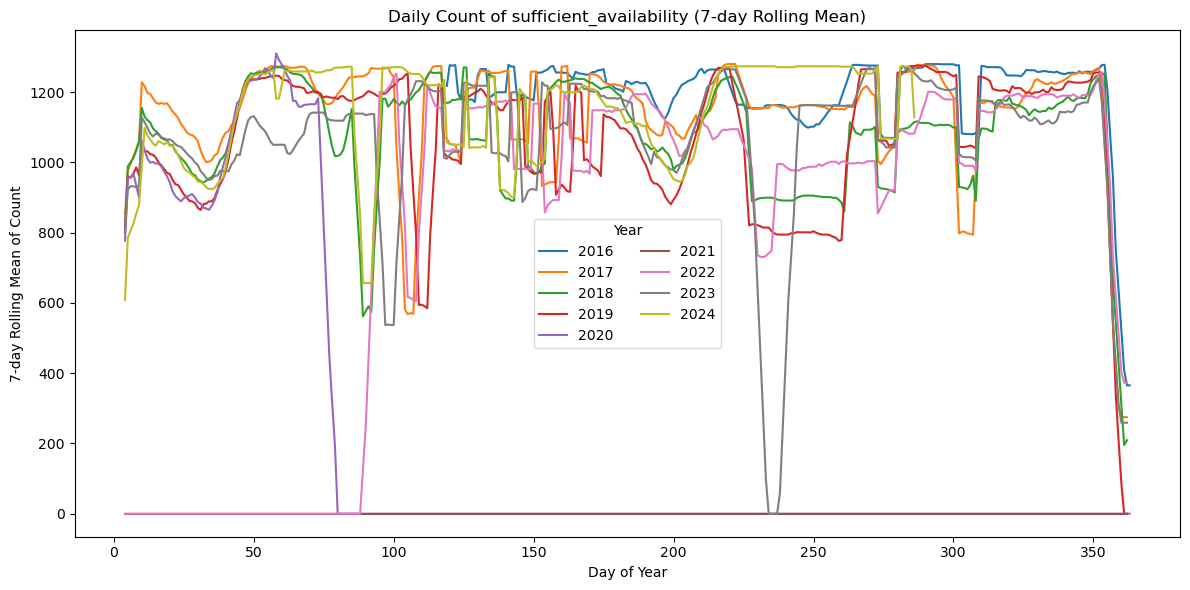

In [26]:
import matplotlib.pyplot as plt

# Keep only rows where sufficient_availability == 1
df_ones = final_data_df[final_data_df["sufficient_availability"] == 1]

# Count number of 1s per day
daily_counts = df_ones.resample("D").size()

# Prepare dataframe for plotting
plot_df = daily_counts.to_frame("count")
plot_df["year"] = plot_df.index.year
plot_df["day_of_year"] = plot_df.index.dayofyear

# Remove Feb 29 for consistent year length
plot_df = plot_df[~((plot_df.index.month == 2) & (plot_df.index.day == 29))]

# 7-day rolling mean (done separately per year)
plot_df["count_7d"] = (
    plot_df
    .groupby("year")["count"]
    .rolling(window=7, center=True)
    .mean()
    .reset_index(level=0, drop=True)
)

# Plot
plt.figure(figsize=(12, 6))

for year, group in plot_df.groupby("year"):
    plt.plot(
        group["day_of_year"],
        group["count_7d"],
        label=str(year)
    )

plt.xlabel("Day of Year")
plt.ylabel("7-day Rolling Mean of Count")
plt.title("Daily Count of sufficient_availability (7-day Rolling Mean)")
plt.legend(title="Year", ncol=2)
plt.tight_layout()
plt.show()

# not very helpful; apparently, we have to many "holes" in the data for 

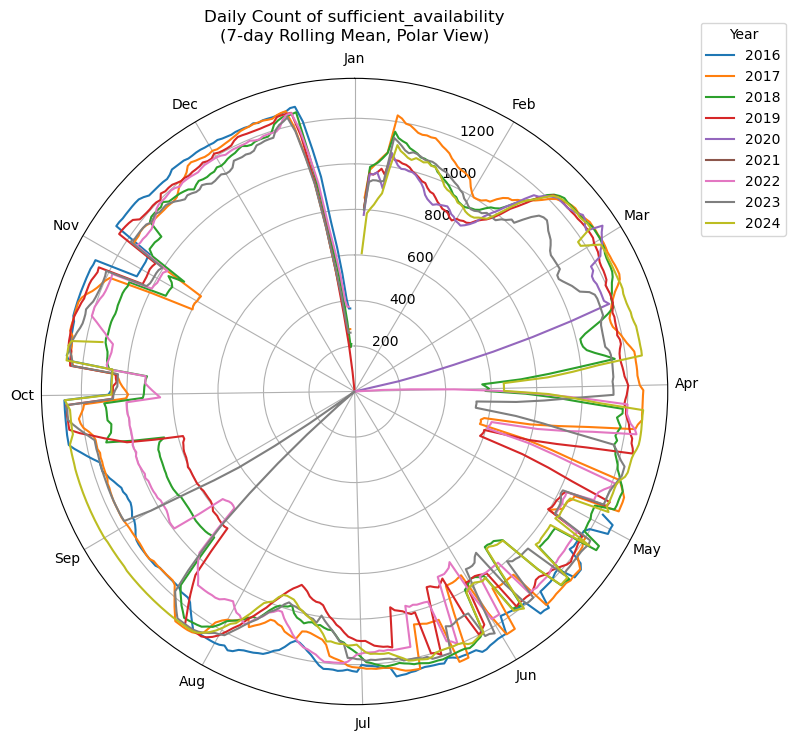

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Keep only rows where sufficient_availability == 1
df_ones = final_data_df[final_data_df["sufficient_availability"] == 1]

# Count number of 1s per day
daily_counts = df_ones.resample("D").size()

# Prepare dataframe
plot_df = daily_counts.to_frame("count")
plot_df["year"] = plot_df.index.year
plot_df["day_of_year"] = plot_df.index.dayofyear

# Remove Feb 29 for consistent year length
plot_df = plot_df[~((plot_df.index.month == 2) & (plot_df.index.day == 29))]

# 7-day rolling mean per year
plot_df["count_7d"] = (
    plot_df
    .groupby("year")["count"]
    .rolling(window=7, center=True)
    .mean()
    .reset_index(level=0, drop=True)
)

# Convert day of year to angle (radians)
plot_df["theta"] = 2 * np.pi * (plot_df["day_of_year"] - 1) / 365

# ---- POLAR PLOT ----
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="polar")

# Plot each year
for year, group in plot_df.groupby("year"):
    ax.plot(group["theta"], group["count_7d"], label=str(year))

# Polar formatting
ax.set_theta_zero_location("N")   # 0° at the top
ax.set_theta_direction(-1)        # clockwise
ax.set_title(
    "Daily Count of sufficient_availability\n(7-day Rolling Mean, Polar View)",
    va="bottom"
)

# Add month labels
months = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # approximate start of each month (ignoring leap day)
month_angles = [2 * np.pi * (d - 1) / 365 for d in month_days]

ax.set_xticks(month_angles)
ax.set_xticklabels(months)

ax.legend(title="Year", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


/tmp/nix-shell.0OH1vU/ipykernel_10439/1761945350.py:12: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: 100 * x.sum() / x.count()


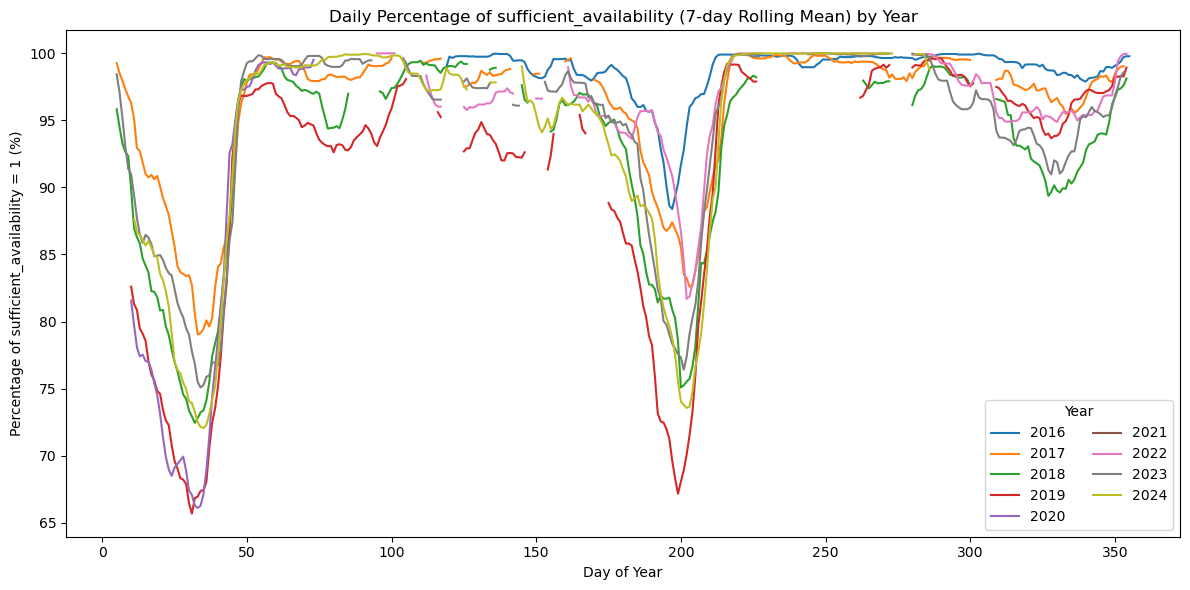

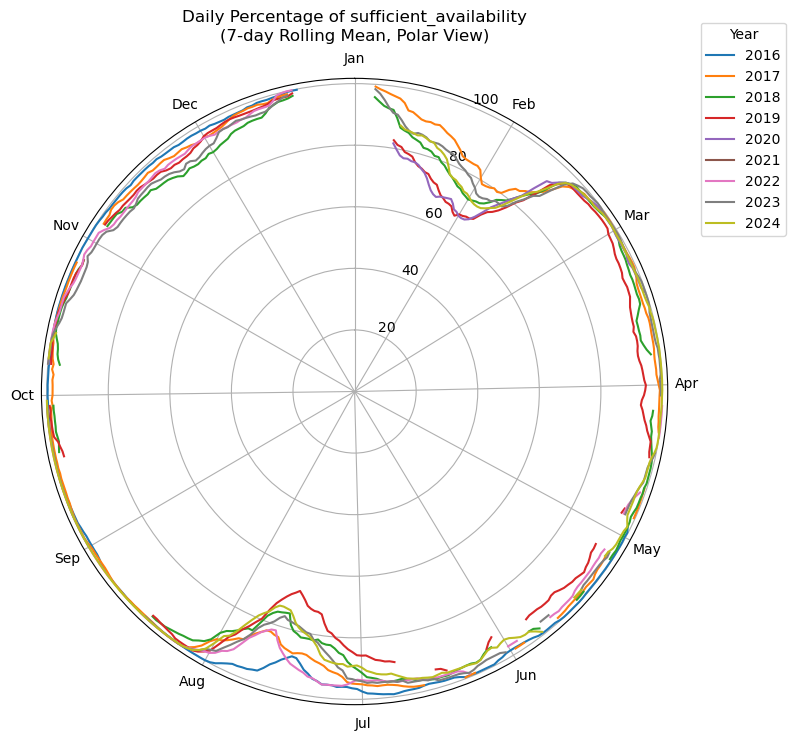

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import calendar

# ---- STEP 1: Prepare daily percentage ----

df = final_data_df.copy()
df.index = pd.to_datetime(df.index)  # ensure datetime index

# Compute daily percentage of ones (Series)
daily_percent = df.resample("D")["sufficient_availability"].apply(
    lambda x: 100 * x.sum() / x.count()
)
daily_percent.name = "percent_ones"  # correct way to rename a Series

# Remove Feb 29 for consistent year length
daily_percent = daily_percent[~((daily_percent.index.month == 2) & (daily_percent.index.day == 29))]

# Create DataFrame for plotting
daily_stats = daily_percent.to_frame()
daily_stats["year"] = daily_stats.index.year
daily_stats["day_of_year"] = daily_stats.index.dayofyear

# 7-day rolling mean per year
daily_stats["percent_7d"] = (
    daily_stats.groupby("year")["percent_ones"]
    .rolling(window=7, center=True)
    .mean()
    .reset_index(level=0, drop=True)
)

# ---- PLOT ONE: Line plot ----
plt.figure(figsize=(12, 6))
for year, group in daily_stats.groupby("year"):
    plt.plot(group["day_of_year"], group["percent_7d"], label=str(year))

plt.xlabel("Day of Year")
plt.ylabel("Percentage of sufficient_availability = 1 (%)")
plt.title("Daily Percentage of sufficient_availability (7-day Rolling Mean) by Year")
plt.legend(title="Year", ncol=2)
plt.tight_layout()
plt.show()

# ---- PLOT TWO: Polar plot ----
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="polar")

# Convert day of year to angle
daily_stats["theta"] = 2 * np.pi * (daily_stats["day_of_year"] - 1) / 365

for year, group in daily_stats.groupby("year"):
    ax.plot(group["theta"], group["percent_7d"], label=str(year))

# Polar formatting
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title(
    "Daily Percentage of sufficient_availability\n(7-day Rolling Mean, Polar View)",
    va="bottom"
)

# Month labels
months = list(calendar.month_abbr)[1:]
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_angles = [2 * np.pi * (d - 1) / 365 for d in month_days]
ax.set_xticks(month_angles)
ax.set_xticklabels(months)

ax.legend(title="Year", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


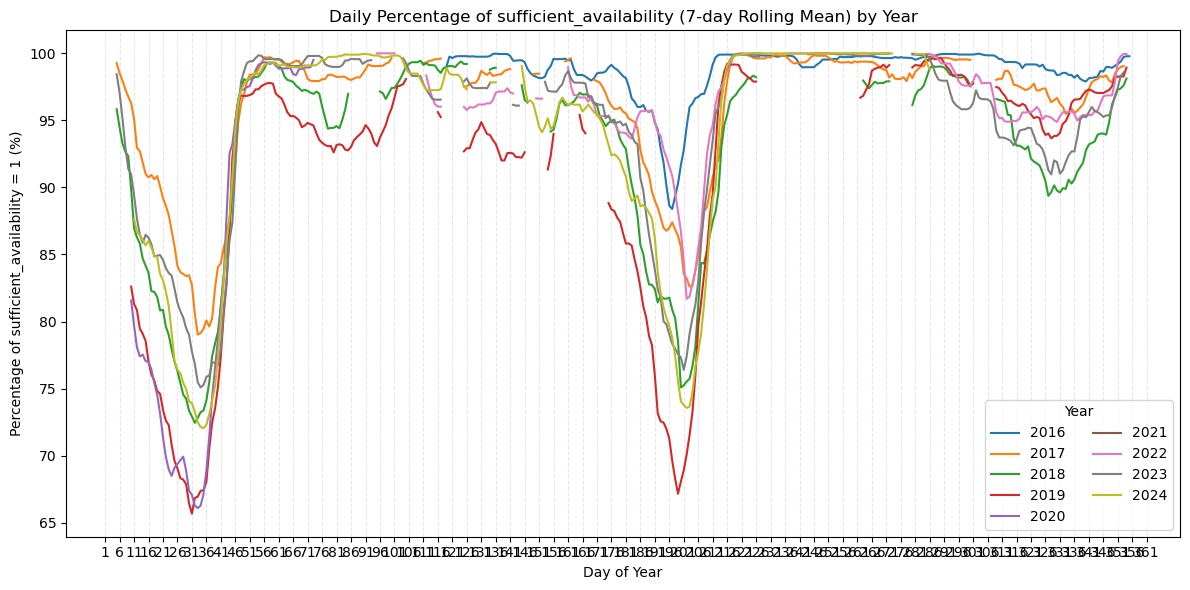

In [32]:
plt.figure(figsize=(12, 6))

for year, group in daily_stats.groupby("year"):
    plt.plot(group["day_of_year"], group["percent_7d"], label=str(year))

# Add vertical grid lines for every 5th day
plt.xticks(np.arange(1, 366, 5))        # tick every 5 days
plt.grid(axis='x', linestyle='--', alpha=0.3)  # faint vertical lines

plt.xlabel("Day of Year")
plt.ylabel("Percentage of sufficient_availability = 1 (%)")
plt.title("Daily Percentage of sufficient_availability (7-day Rolling Mean) by Year")
plt.legend(title="Year", ncol=2)
plt.tight_layout()
plt.show()


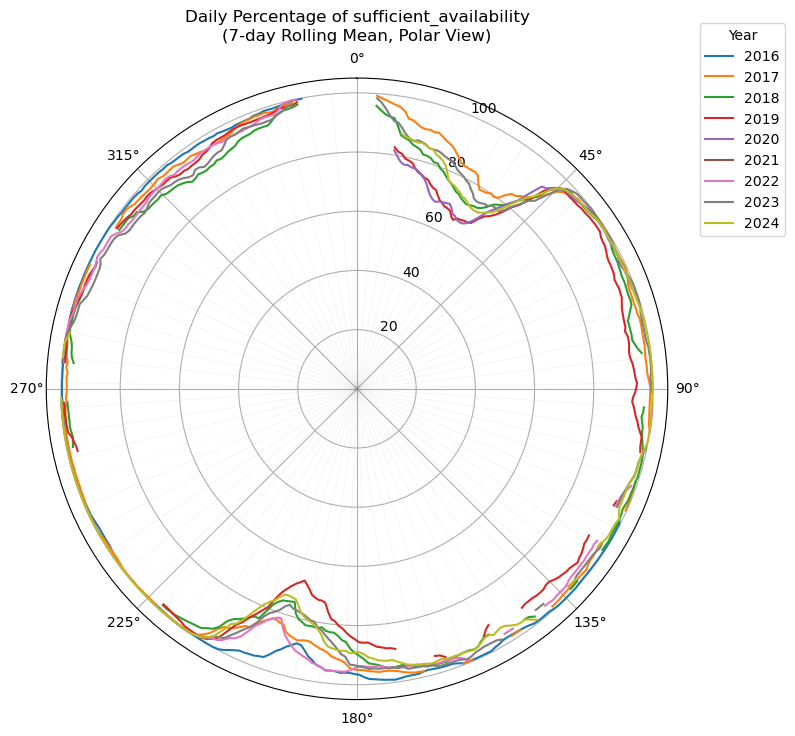

In [33]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="polar")

for year, group in daily_stats.groupby("year"):
    ax.plot(group["theta"], group["percent_7d"], label=str(year))

# Polar formatting
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title(
    "Daily Percentage of sufficient_availability\n(7-day Rolling Mean, Polar View)",
    va="bottom"
)

# Add radial lines every 5 days
daily_angles_5 = 2 * np.pi * (np.arange(1, 366, 5) - 1) / 365
for angle in daily_angles_5:
    ax.plot([angle, angle], [0, 100], color='gray', alpha=0.1, lw=0.5)  # faint radial line

ax.legend(title="Year", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()
